In [1]:
%%capture
from __future__ import print_function
import os
import ipywidgets as ipyw
from ipywidgets import Dropdown, Checkbox, FloatText, IntSlider, Label, HBox, VBox
from IPython.display import clear_output
import pandas as pd
import matplotlib.pyplot as plt
import IPython
import warnings
warnings.filterwarnings("ignore")
import mjknowling
import time
import shutil
import platform
print("running on...: {}".format(platform.platform()))

In [2]:
%matplotlib inline

In [3]:
### Installing VineLOGIC R package - after building *.tar.gz file; see https://gitlab.com/mjknowling/da_opt_vinelogic
call = 'R CMD INSTALL VineLOGIC_0.1.0.tar.gz'
r = os.system(call)
if r != 0:
    raise Exception("VineLOGIC build/install failed... go to https://gitlab.com/mjknowling/da_opt_vinelogic")

In [4]:
### My Vineyard

In [5]:
variety_d = {'variety': ['shiraz']}
variety_widget = Dropdown( options=variety_d['variety'],
                         value='shiraz',
                         description='variety',
                       )
rootstock_d = {'rootstock': ['Schwartzmann']}
rootstock_widget = Dropdown( options=rootstock_d['rootstock'],
                         value='Schwartzmann',
                         description='rootstock',
                       )
#style = {'description_width': 'initial'}
#entitl_widget = FloatText( value=10.0, step=1, )#description='entitlement (ML)', style=style)
#entitl_widget = HBox([Label('entitl. (ML)'), entitl_widget])
left_box = VBox([variety_widget, ])#entitl_widget])
right_box = VBox([rootstock_widget])
#HBox([left_box, right_box])

### Management Scenarios

In [6]:
def updateScen(**kwargs):
    #print([(k,v) for k, v in kwargs.items()])?
    updateScen.sel_scens = {k: v for k, v in kwargs.items() if v is True}

In [7]:
scen_names = {}
scen_fnames = [x for x in os.listdir() if ".json" in x]
for js in scen_fnames:
    scen_names[js] = pd.read_json(os.path.join(js)).keys()[0]  #.tolist())
#scen_names = [x.strip(".json") for x in os.listdir() if "Scenario" in x and ".json" in x]
#print(scen_names)

In [8]:
chk = [Checkbox(description=x, value=True) for i, x in scen_names.items()]
#l_box, c_box, r_box = VBox([chk[0]]), VBox([chk[1]]), VBox([chk[2]])
#HBox([l_box, c_box, r_box])

ipyw.interactive(updateScen, **{c.description: c.value for c in chk})

interactive(children=(Checkbox(value=True, description='Simulation'), Checkbox(value=True, description='Scen02…

In [9]:
#scen0_chk = Checkbox(value=False, description=scen_names[0], disabled=False, indent=False)
#scen1_chk = Checkbox(value=False, description=scen_names[1], disabled=False, indent=False)
#scen2_chk = Checkbox(value=False, description=scen_names[2], disabled=False, indent=False)

In [10]:
#ipyw.interact(updatePlot, **{scen0_chk.description: scen0_chk.value})
#ipyw.interact(updatePlot, **{scen1_chk.description: scen1_chk.value})
#ipyw.interact(updatePlot, **{scen2_chk.description: scen2_chk.value})

In [11]:
def process_scen_json(scen_json_fname):
    mapper = {"Crush Price": "grape_price", 
              "Maximum irrigation mm per phenology": "IRSTAGECAP",
              "Maximum daily irrigation mm per phenology": "IRDAYSTAGECAP",
              "Water market cost": "water_market_rate",
              "Water delivery cost": "water_delivery_rate",
              "Water entitlement": "water_entitlement",
              "Cost per tip": "costs_per_tip", "Number of tips": "ntips",
              "Cost per spray": "costs_per_spray", "Number of sprays": "nsprays",
              "Days between irrigation applications per phenology": "IRRETNPERIOD", 
              "Soil water irrigation trigger per phenology": "IRCRITSW",
              "Soil water irrigation defict refill percent per phenology": "IRREFILLPER", 
             }
    d = {}
    js = pd.read_json(os.path.join(scen_json_fname))
    js = js[js.keys()[0]]  # there is only one scen per file
    for k, v in js.items():
        if k != "Description":
            d[mapper[k]] = v["Value"]
            #if "irr" in k:
             #   print(k)
              #  d[mapper[k]]["Value"] = v["Value"]
               # d[mapper[k]]["vinelogic_file"] = "RuleBasedIrrigation.json"
            #else:
             #   d[mapper[k]] = v["Value"]
    #   sorted()
    #for js in js.unique():
    #update
    #write
    return d

In [12]:
def scen_json_to_vinelogic(d, ws):
    for k, v in d[ws].items():
        #print("k, v: {0} {1}".format(k, v))
        
        # TODO: read json here then loop over vars!
        
        if k == "IRSTAGECAP":  # max over phenological stage(s)
            f = "RuleBasedIrrigationData.json"
            df = pd.read_json(os.path.join(ws, f))
            od = df[k]["Value"]
            if isinstance(v, float):
                #print("uniform max irr mm: {}".format(v))
                #print(df["IRSTAGECAP"]["Value"])
                df[k]["Value"] = [v for x in od]
                #print(df["IRSTAGECAP"]["Value"])
                df.to_json(os.path.join(ws, f), indent=4)
            elif isinstance(v, list) and len(v) == 5:
                df[k]["Value"] = v
                df.to_json(os.path.join(ws, f), indent=4)
            else:
                raise Exception
                
        # TODO: impose daily maximum on VineLOGIC
                
        # fresh code
        elif k == "IRREFILLPER":
            f = "RuleBasedIrrigationData.json"
            df = pd.read_json(os.path.join(ws, f))
            od = df[k]["Value"]
            if isinstance(v, float):
                #print(df["IRREFILLPER"]["Value"])
                df[k]["Value"] = [v for x in od]
                #print(df["IRREFILLPER"]["Value"])
                df.to_json(os.path.join(ws, f), indent=4)
            elif isinstance(v, list) and len(v) == 5:
                df[k]["Value"] = v
                df.to_json(os.path.join(ws, f), indent=4)
            else:
                raise Exception
        elif k == "IRCRITSW":
            f = "RuleBasedIrrigationData.json"
            df = pd.read_json(os.path.join(ws, f))
            od = df[k]["Value"]
            if isinstance(v, float):
                #print(df["IRCRITSW"]["Value"])
                df[k]["Value"] = [v for x in od]
                #print(df["IRCRITSW"]["Value"])
                df.to_json(os.path.join(ws, f), indent=4)
            elif isinstance(v, list) and len(v) == 5:
                df[k]["Value"] = v
                df.to_json(os.path.join(ws, f), indent=4)
            else:
                raise Exception
        elif k == "IRRETNPERIOD":
            f = "RuleBasedIrrigationData.json"
            df = pd.read_json(os.path.join(ws, f))
            od = df[k]["Value"]
            if isinstance(v, float):
                #print(df["IRRETNPERIOD"]["Value"])
                df[k]["Value"] = [v for x in od]
                #print(df["IRRETNPERIOD"]["Value"])
                df.to_json(os.path.join(ws, f), indent=4)
            elif isinstance(v, list) and len(v) == 5:
                df[k]["Value"] = v
                df.to_json(os.path.join(ws, f), indent=4)
            else:
                raise Exception
        elif k == "IRDAYSTAGECAP":
            f = "RuleBasedIrrigationData.json"
            df = pd.read_json(os.path.join(ws, f))
            od = df[k]["Value"]
            if isinstance(v, float):
                #print(df["IRDAYSTAGECAP"]["Value"])
                df[k]["Value"] = [v for x in od]
                #print(df["IRDAYSTAGECAP"]["Value"])
                df.to_json(os.path.join(ws, f), indent=4)
            elif isinstance(v, list) and len(v) == 5:
                df[k]["Value"] = v
                df.to_json(os.path.join(ws, f), indent=4)
            else:
                raise Exception
                
        # bud no.... related to pruning strategy

In [13]:
def on_button_clicked(b):
    
    clear_output()
    display(button)
    
    #sel_scens = []
    #if scen0_chk.value:
    #    sel_scens.append(scen0_chk.description)
    #if scen1_chk.value:
    #    sel_scens.append(scen1_chk.description)
    #if scen2_chk.value:
    #    sel_scens.append(scen2_chk.description)
    #print(sel_scens)
    if len(updateScen.sel_scens) == 0:
        raise Exception("Nothing to do - no scenarios to evaluate....")
    ss = updateScen.sel_scens
    #print(ss)
        
    sel_scens = {}
    for i in ss:
        f = {k: v for k, v in scen_names.items() if v == i}
        #f = list(f.keys())
        sel_scens.update(f)
    #print(sel_scens)
    on_button_clicked.sel_scens = sel_scens
    
    # for old
    sel_scens = [k for k, v in sel_scens.items()]
        
    base_d = "_base"
    temp_d = "_simulations"
    on_button_clicked.scen_d = {}
    #print(sel_scens)
    for sjf in sel_scens:
        #s = s[0]
        #print("scen: {}".format(s))
        
        # cp ws
        s = sjf.split(".json")[0]
        if os.path.exists(s):
            shutil.rmtree(s)
        #if not os.path.exists(sel_scens):
         #   os.mkdir(sel_scens)
        shutil.copytree(base_d, s)

        #sjf = s + ".json"
        #print(sjf)
        d = process_scen_json(scen_json_fname=sjf)
        #print(d)
        #TODO
        #scen_d = mjknowling.process_scen_json()
        #TODO
        #print(on_button_clicked.scen_d)
        on_button_clicked.scen_d[s] = d
        #print("scen_d: ")
        #print(on_button_clicked.scen_d)

        scen_json_to_vinelogic(d=on_button_clicked.scen_d, ws=s)
        #TODO
        #mjknowling.scen_json_to_vinelogic(d=on_button_clicked.scen_d, ws=s)
        #TODO
        
        # now run
        #s = str_d['irrigation'].value
        _ = mjknowling.run_scen("temp", scen_d=on_button_clicked.scen_d)
        #print("evaluation of {} complete".format(s))
        #plot = p_d['plot'].value
        #print("plotting {}".format(plot))
        #mjknowling.plot_scen(scens, plot)
        
    return on_button_clicked.scen_d, on_button_clicked.sel_scens

In [14]:
button = ipyw.Button(description="Evaluate Scenario(s)")
button.on_click(on_button_clicked)
display(button)

Button(description='Evaluate Scenario(s)', style=ButtonStyle())

### Seasonal projections

In [15]:
def plot_request_mapper(l1w, l2w):
    plot_str = ipyw.Text("0.5")
    p_d = {"plot": plot_str}
    if l1w.value is not None and l2w is not None:
        if l1w.value == "irrigation":
            if l2w.value == "time series":
                p_d['plot'].value = 'irrigationtimeseries'
            elif l2w.value == "total":
                p_d['plot'].value = 'irrigationtotal'
        elif l1w.value == "infiltration" and l2w.value == "time series":
            p_d['plot'].value = 'infiltrationts'
        elif l1w.value == "evaporation" and l2w.value == "time series":
            p_d['plot'].value = 'evaporationts'
        elif l1w.value == "soil moisture" and l2w.value == "time series":
            p_d['plot'].value = 'soilmoisturets'
        elif l1w.value == "drainage" and l2w.value == "time series":
            p_d['plot'].value = 'drainagets'
        elif l1w.value == "water table" and l2w.value == "time series":
            p_d['plot'].value = 'watertablets'
        elif l1w.value == "soil water deficit irrigation trigger" and l2w.value == "time series":
            p_d['plot'].value = 'athetats'
        elif l1w.value == "tswtop" and l2w.value == "time series":
            p_d['plot'].value = 'tswtopts'
        elif l1w.value == "wet1" and l2w.value == "time series":
            p_d['plot'].value = 'wet1ts'
        elif l1w.value == "root uptake" and l2w.value == "time series":
            p_d['plot'].value = 'rootuptakets'
        elif l1w.value == "rainfall":
            if l2w.value == "time series":
                p_d['plot'].value = 'raints'
            elif l2w.value == "total":
                p_d['plot'].value = 'raintotal'
        elif l1w.value == "ponding" and l2w.value == "time series":
            p_d['plot'].value = 'pondts'
        elif l1w.value == "runoff" and l2w.value == "time series":
            p_d['plot'].value = 'runoffts'
        elif l1w.value == "costs" and l2w.value == "irrigation":
            p_d['plot'].value = 'irrigationcost'
        elif l1w.value == "end of season" and l2w.value == "yield":
            p_d['plot'].value = 'harvestyield'
        elif l1w.value == "revenue" and l2w.value == "crush":
            p_d['plot'].value = 'harvestrevenue'
        elif l1w.value == "growth":
            if l2w.value == "canopy":
                p_d['plot'].value = 'laitimeseries'
            elif l2w.value == "fruit":
                p_d['plot'].value = 'fruittimeseries'
            elif l2w.value == "Brix":
                p_d['plot'].value = 'brixtimeseries'
        elif l1w.value == "key dates":
            #p_d['plot'].value = l2w.value
            if l2w.value == "bud burst":
                p_d['plot'].value = 'bbdate'
            elif l2w.value == "first flower":
                p_d['plot'].value = 'ffdate'
            elif l2w.value == "veraison":
                p_d['plot'].value = 'vsdate'
            elif l2w.value == "harvest":
                p_d['plot'].value = 'hvdate'
        elif l1w.value == "costs" and l2w.value == "total":
            p_d['plot'].value = 'costcontributions'
        elif l1w.value == "bottom line" and l2w.value == "gross margin":
            p_d['plot'].value = 'grossmargin'
        elif l1w.value == "investigation":
            if l2w.value == "available energy":
                p_d['plot'].value = 'cpoolts'
            elif l2w.value == "fruit energy sink":
                p_d['plot'].value = 'fruitsinkts'
            elif l2w.value == "soil water stress index":
                p_d['plot'].value = 'swstressts'
            elif l2w.value == "potential vine ET":
                p_d['plot'].value = 'VineEop'
            elif l2w.value == "potential root uptake":
                p_d['plot'].value = 'Tru'
            #elif l2w.value == "supply v demand":
             #   p_d['plot'].value = 'supplydemand'
        else:
            p_d['plot'].value = 'underdev'
    else:
        raise Exception("Please select an option from each of the drop-down menus")
    return p_d

In [16]:
d0 = {'how my vine is developing' : ['growth', 'key dates', 'end of season', 'investigation'], 
      'where my water is going' : ['irrigation', 'rainfall', 'ponding', 'runoff', 'evaporation', 
                                   'infiltration', 'soil moisture', 'soil water deficit irrigation trigger',  
                                   'root uptake', 'drainage'],#'tswtop', 'wet1','water table'
      'what my financial position is': ['revenue', 'costs', 'bottom line']}
d1 = {v: [] for v in [x for y in list(d0.values()) for x in y]}  # one level? at a time - to avoid multi-index hassle
d1['irrigation'] = ['time series', 'total']
d1['infiltration'] = ['time series']
d1['evaporation'] = ['time series']
d1['soil moisture'] = ['time series']
d1['soil water deficit irrigation trigger'] = ['time series']
#d1['tswtop'] = ['time series']
#d1['wet1'] = ['time series']
d1['drainage'] = ['time series']
#d1['water table'] = ['time series']
d1['root uptake'] = ['time series']
d1['rainfall'] = ['time series', 'total']
d1['ponding'] = ['time series']
d1['runoff'] = ['time series']
d1['key dates'] = ['bud burst', 'first flower', 'veraison', 'harvest']
d1['investigation'] = ['available energy', 'fruit energy sink', 'fruit energy supply vs demand', 'soil water stress index', 
                       'potential vine ET', 'potential root uptake', 'vreserve', 'vcarbo', 'pcarb']
d1['growth'] = ['canopy', 'berry number per shoot',  'berry number per vine', 'shoot number', 'fruit', 'Brix']
d1['end of season'] = ['yield']
d1['revenue'] = ['crush']
d1['costs'] = ['irrigation', 'total']  #'labour', 'diesel', 'chemical', 
d1['bottom line'] = ['gross margin']

level0_widget = Dropdown( options=list(d0.keys()),
                         value='how my vine is developing',
                         description='',
                       )
level1_widget = Dropdown( options=d0['how my vine is developing'],
                         value=None,
                         description='',
                       )
level2_widget = Dropdown( options=d0['how my vine is developing'],
                         value=None,
                         description='',
                       )

def on_update_widget_level0(*args):
    level1_widget.options = d0[level0_widget.value]
level0_widget.observe(on_update_widget_level0, 'value')

def on_update_widget_level1(*args):
    level2_widget.options = d1[level1_widget.value]
level1_widget.observe(on_update_widget_level1, 'value')

In [17]:
def on_change1(change):
    not_in_l = d0['how my vine is developing'] + d0['what my financial position is']
    if change['type'] == 'change' and change['name'] == 'value':
        # TODO: tidy
        if "water" in level0_widget.value and ("irrigation" not in level1_widget.value or 
                                              ("irrigation" in level1_widget.value and (
                                               change['old'] is not None and "irrigation" not in change['old']
                                               and "revenue" not in change['old'] and "costs" not in change['old']
                                               and "bottom line" not in change['old'] and "growth" not in change['old']
                                               and "key dates" not in change['old'] 
                                               and "end of season" not in change['old']))):
            print(change)
            on_change(change)

def on_change2(change):
    if change['type'] == 'change' and change['name'] == 'value':
        if "water" not in level0_widget.value or (
            "water" in level0_widget.value and "irrigation" in level1_widget.value) or (
            "water" in level0_widget.value and "rain" in level1_widget.value):
            print(change)
            on_change(change)
            
def on_change(change):
    #plt.close()
    #print("changed to {}".format(change['new']))
    clear_output()
    display(HBox([l_box, c_box, r_box]))
    #display(button)
    #irrig = str_d['irrigation'].value
    #print("evaluating {} irrigation scenario with respect to base scenario...".format(irrig))
    
    # TODO: drop irrig scen
    #scens = mjknowling.run_scen(irrig, scen_d=scen_d)
    
    p_d = plot_request_mapper(l1w=level1_widget, l2w=level2_widget)
    plot = p_d['plot'].value
    time.sleep(.001)
    #print(on_button_clicked.scen_d, on_button_clicked.sel_scens)
    dd = {}
    try:
        on_button_clicked.sel_scens
        on_button_clicked.scen_d
    except AttributeError:
        print("Please Evaluate Scenario(s)")
    for k, v in on_button_clicked.sel_scens.items():
        dd[v] = on_button_clicked.scen_d[k.strip(".json")]
    #print(list(on_button_clicked.scen_d.keys()))
    cd = {}
    for k, v in on_button_clicked.sel_scens.items():
        cd[k.strip(".json")] = on_button_clicked.sel_scens[k]
    #print("plotting {}".format(plot))
    #print(cd, plot, dd)
    mjknowling.plot_scen(cd, plot, scen_d=dd)#on_button_clicked.scen_d)

In [18]:
level1_widget.observe(on_change1)
level2_widget.observe(on_change2)

In [19]:
#on_button_clicked.sel_scens, on_button_clicked.scen_d

In [20]:
print('I want to know...')

I want to know...


In [21]:
ipyw.interactive(updateScen, **{c.description: c.value for c in chk})

interactive(children=(Checkbox(value=True, description='Simulation'), Checkbox(value=True, description='Scen02…

In [22]:
display(button)

Button(description='Evaluate Scenario(s)', style=ButtonStyle())

            soil_water_top  soil_water_mid  soil_water_bot
2020-08-31             0.0             0.0             0.0
2020-09-01             0.0             0.0             0.0
2020-09-02             0.0             0.0             0.0
2020-09-03             0.0             0.0             0.0
2020-09-04             0.0             0.0             0.0
            soil_water_top  soil_water_mid  soil_water_bot
2020-08-31             0.0             0.0             0.0
2020-09-01             0.0             0.0             0.0
2020-09-02             0.0             0.0             0.0
2020-09-03             0.0             0.0             0.0
2020-09-04             0.0             0.0             0.0


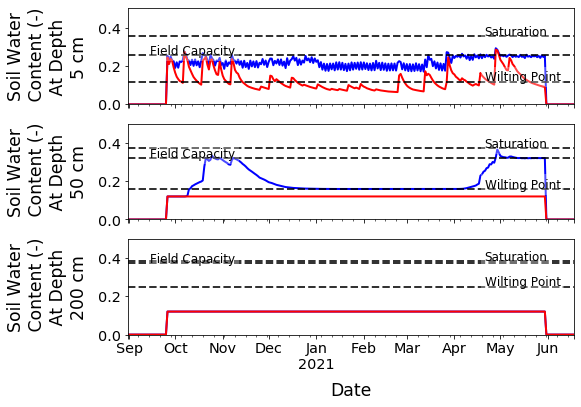

In [23]:
l_box, c_box, r_box = VBox([level0_widget]), VBox([level1_widget]), VBox([level2_widget])
display(HBox([l_box, c_box, r_box]))